In [1]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle
from tqdm.notebook import tqdm
import japanize_matplotlib
import matplotlib.cm as cm

!pip install japanize-matplotlib

In [2]:
path_1 = "./folder_05/"
file_mesh = 'mesh_list_2021.pickle'
file_hsdn = "hsdn.csv"
file_category =  "category.csv"

In [3]:
#HSDN読込
hsdn = pd.read_csv(path_1+file_hsdn)
print(len(hsdn))
hsdn = hsdn[hsdn["cosine_similarity"]>0.1]#閾値設定
print("--> 閾値cos＞0.1:", len(hsdn))


7804331
--> 閾値cos＞0.1: 1584355


In [4]:
#target疾患のMeSH表記形リスト作成
#（2型糖尿病、1型糖尿病、関節炎・リウマチ、統合失調症）
target_list = ["Diabetes Mellitus, Type 2", "Diabetes Mellitus, Type 1", "Arthritis, Rheumatoid","Schizophrenia" ]
#target疾患の疾患リンク数
for i in target_list:
    print(i, len(hsdn[(hsdn["disease_1"]==i)|(hsdn["disease_2"]==i)]))

Diabetes Mellitus, Type 2 635
Diabetes Mellitus, Type 1 429
Arthritis, Rheumatoid 1421
Schizophrenia 289


In [5]:
#2021_mesh
with open(file_mesh, 'rb') as f:
    mesh_list = pickle.load(f)

#Zhouらの定義した疾患MeSH
all_disease = [descriptor for descriptor in mesh_list for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]

#重複削除
disease_mesh = []
[dm for dm in all_disease if dm not in disease_mesh and not disease_mesh.append(dm)]

print("all_mesh:", len(mesh_list), "disease_mesh:", len(disease_mesh))

all_mesh: 29917 disease_mesh: 4887


In [6]:
#treecode単位にMeSHデータをばらす
each_category = [[i[1], category] for i in disease_mesh for category in i[2]]
print(len(each_category))

12542


In [7]:
#臓器の日本語名(ja)で分類する
#「臓器名か臓器+diseases等…」を持つメッシュ語彙を探し、その英語表記形(en)とツリー番号(treecode)を取り出したもの
cate_ja = pd.read_csv(path_1+file_category)

In [8]:
zouki_list = ["脳","末梢神経","心臓","心臓血管","胆嚢","虫垂","大腸","膵臓","小腸","胃","脾臓","肝臓","皮膚",
              "目","筋肉","骨格","肺","性腺","腎臓"] 
cate_ja = pd.read_csv(path_1+file_category)

In [9]:
#treecode単位でばらしたMeSHデータのうち日本語分類cate_jaのtreecodeに属しているもの を取り出す
cate_ja_df = pd.DataFrame()
for term in each_category:
    for ja, treecode in zip(cate_ja["ja"], cate_ja["treecode"]):
        if term[1].startswith(treecode):
            tmp_df = pd.DataFrame([term[0], term[1], ja, treecode]).T
            cate_ja_df = pd.concat([cate_ja_df, tmp_df], axis=0)
cate_ja_df.columns=["disease_2", "mesh_treecode", "ja", "ja_mesh_treecode"]
cate_ja_df = cate_ja_df.reset_index(drop=True)
print(len(cate_ja_df))

3441


In [10]:
#色 Pastel1
color_list = ["#fbb4ae", "#b3cde3", "#ccebc5", "#decbe4", "#fed9a6", "#ffffcc", "#e5d8bd", "#fddaec", "#f2f2f2" ]

In [11]:
#器官系別に色を塗る

category_color = {}
for i in zouki_list:
    #神経系
    if (i == "脳") | (i=="末梢神経"):
        category_color = {**category_color,**dict([(i, color_list[0])])}
    #循環器系 
    if (i == "心臓") | (i=="心臓血管") | (i=="脾臓"):
        category_color = {**category_color,**dict([(i, color_list[1])])}
    #消化器系
    if (i == "胆嚢") | (i=="虫垂") | (i=="大腸") | (i=="膵臓") | (i=="小腸") | (i=="胃") | (i=="肝臓"):
        category_color = {**category_color,**dict([(i, color_list[2])])}            
    #感覚器系
    if (i == "皮膚") | (i=="目"):
        category_color = {**category_color,**dict([(i, color_list[3])])}
    #筋骨格系
    if (i == "筋肉") | (i=="骨格"): 
        category_color = {**category_color,**dict([(i, color_list[4])])}
    #呼吸器系
    if (i == "肺"):
        category_color = {**category_color,**dict([(i, color_list[5])])}
    #内分泌系
    if (i == "性腺") :
        category_color = {**category_color,**dict([(i, color_list[6])])}
    #泌尿器系
    if (i == "腎臓") :
        category_color = {**category_color,**dict([(i, color_list[7])])}

In [12]:
#グラフの設定
color_data = pd.DataFrame(list(category_color.items()),  columns=['zouki', 'color'])
plt.style.use('ggplot')
plt.rcParams.update({'font.size':12})
size=(5,4)#横長に

In [13]:
#円グラフ作成関数の定義

def make_pie(target):
    
    #disease_1列がtargetのもの
    tmp_df = hsdn[(hsdn["disease_1"]==target)].reset_index(drop=True)
    #disease_2列がtargetのもの
    tmptmp_df = hsdn[(hsdn["disease_2"]==target)][["disease_2", "disease_1","cosine_similarity"]].reset_index(drop=True)
    #tmp_dfと合体させるため列名を変更
    tmptmp_df = tmptmp_df.rename(columns={"disease_2":"disease_1", "disease_1":"disease_2"})
    #合体
    df = pd.concat([tmp_df, tmptmp_df], axis=0)
    df = df.sort_values(by="cosine_similarity", ascending=False)
    df = df.reset_index(drop=True)
    print(len(df))

    target_with_category= pd.merge(df, cate_ja_df, on="disease_2")
    target_with_category.to_csv(target+".csv", index=False)
    #target_with_category.to_csv(target+".tsv", index=False, sep="\t")
    
    pie_data_ = target_with_category.value_counts("ja")
    pie_data = pd.DataFrame(list(pie_data_.items()),  columns=['zouki', 'value'])
    pie = pd.merge(pie_data, color_data, on="zouki")
    
    labels = pie["zouki"].tolist()
    data =  pie["value"].tolist()
    category_color = dict(zip(pie["zouki"], pie['color']))

    plt.figure(figsize=size, dpi=100)
    plt.pie(data,
            labels=labels,
            colors=[category_color[key] for key in labels],
            counterclock=False,
            startangle=90,
            #比率が3%未満であれば表示しない
            autopct=lambda p:'{:.1f}%'.format(p) if p>=3 else '', #autopct='%1.1f%%',
           )
    
    plt.subplots_adjust(left=0, right=0.7)
    #plt.legend(labels, fancybox=True,loc='center left',bbox_to_anchor=(0.9,0.5)) 
    plt.axis('equal') 
    #plt.savefig(target+'.png',bbox_inches='tight',pad_inches=0.05)
    plt.title(target,loc='right',fontsize=14)
    
    plt.tight_layout()
    plt.show()


635


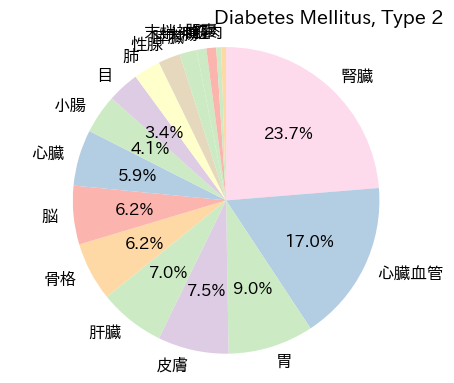

429


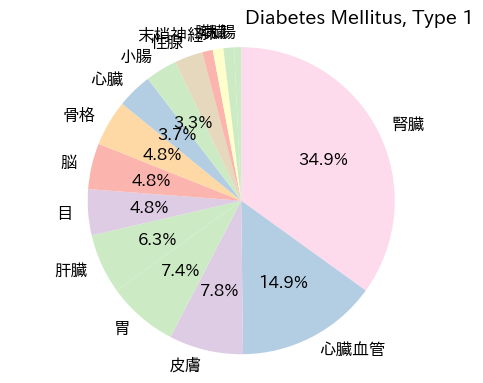

1421


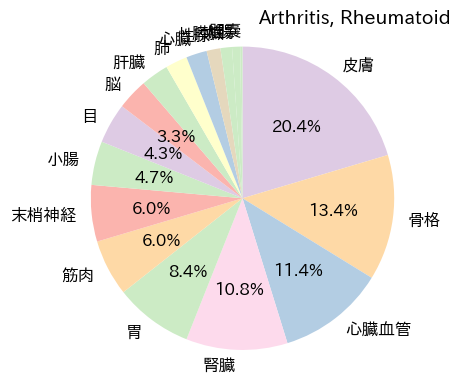

289


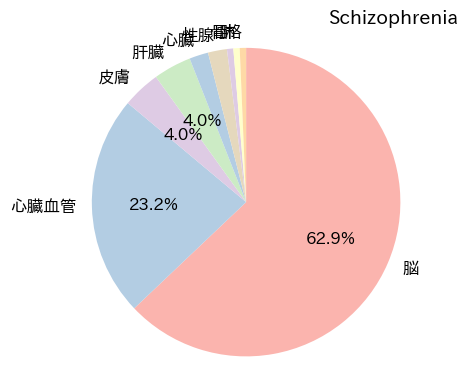

In [14]:
#実行
for target in target_list:
    make_pie(target)